In [25]:
import os
import pandas as pd
import numpy as np
import librosa

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


TORGO_FOLDER = "data/torgo_data"
csv_path = os.path.join(TORGO_FOLDER, "data.csv")
df = pd.read_csv(csv_path)

def fix_path(relative_path):
    prefix = "torgo_data/"
    if relative_path.startswith(prefix):
        relative_path = relative_path[len(prefix):]
    return os.path.join(TORGO_FOLDER, relative_path)

df['audio_path'] = df['filename'].apply(fix_path)

# Remove problematic files
bad_files = {
    "data/torgo_data/dysarthria_female/F01_Session1_0068.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0344.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0346.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0356.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0360.wav"
}
df = df[~df['audio_path'].isin(bad_files)]

df['label'] = df['is_dysarthria'].apply(lambda x: 1 if x == 'dysarthria' else 0)

def extract_features(file_path, sr=16000, n_mfcc=13):
    try:
        y, _ = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        feature_vector = np.concatenate((mfccs_mean, mfccs_std))
        return feature_vector
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

features = []
labels = []

print("Extracting MFCC features...")
for idx, row in df.iterrows():
    feat = extract_features(row["audio_path"])
    if feat is not None:
        features.append(feat)
        labels.append(row["label"])

X = np.array(features)  # shape: (num_samples, 26)
y = np.array(labels)
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
)
print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Test samples:", len(X_test))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

#
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = MFCCDataset(X_train_scaled, y_train)
val_dataset   = MFCCDataset(X_val_scaled, y_val)
test_dataset  = MFCCDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)


class SimpleNN(nn.Module):
    def __init__(self, input_dim=26, hidden_dim=64, output_dim=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")


test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")


Extracting MFCC features...


/opt/anaconda3/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=423
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=421
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=686
  warnings.warn(


Feature matrix shape: (1995, 26)
Labels shape: (1995,)
Train samples: 1596
Validation samples: 199
Test samples: 200
Epoch 1/30 - Train Loss: 0.5419 - Train Acc: 0.7274 - Val Loss: 0.4580 - Val Acc: 0.7940
Epoch 2/30 - Train Loss: 0.3716 - Train Acc: 0.8421 - Val Loss: 0.3695 - Val Acc: 0.8492
Epoch 3/30 - Train Loss: 0.2859 - Train Acc: 0.8822 - Val Loss: 0.3514 - Val Acc: 0.8492
Epoch 4/30 - Train Loss: 0.2455 - Train Acc: 0.8991 - Val Loss: 0.3310 - Val Acc: 0.8693
Epoch 5/30 - Train Loss: 0.2134 - Train Acc: 0.9179 - Val Loss: 0.3259 - Val Acc: 0.8744
Epoch 6/30 - Train Loss: 0.1880 - Train Acc: 0.9311 - Val Loss: 0.3043 - Val Acc: 0.8945
Epoch 7/30 - Train Loss: 0.1625 - Train Acc: 0.9355 - Val Loss: 0.2784 - Val Acc: 0.9095
Epoch 8/30 - Train Loss: 0.1485 - Train Acc: 0.9461 - Val Loss: 0.3017 - Val Acc: 0.9095
Epoch 9/30 - Train Loss: 0.1294 - Train Acc: 0.9543 - Val Loss: 0.2814 - Val Acc: 0.9196
Epoch 10/30 - Train Loss: 0.1108 - Train Acc: 0.9612 - Val Loss: 0.2905 - Val Acc:

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())


y_true = np.array(all_labels)
y_pred = np.array(all_preds)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Healthy", "Dysarthric"]))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.95      0.94      0.94       100
  Dysarthric       0.94      0.95      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200

Confusion Matrix:
[[94  6]
 [ 5 95]]


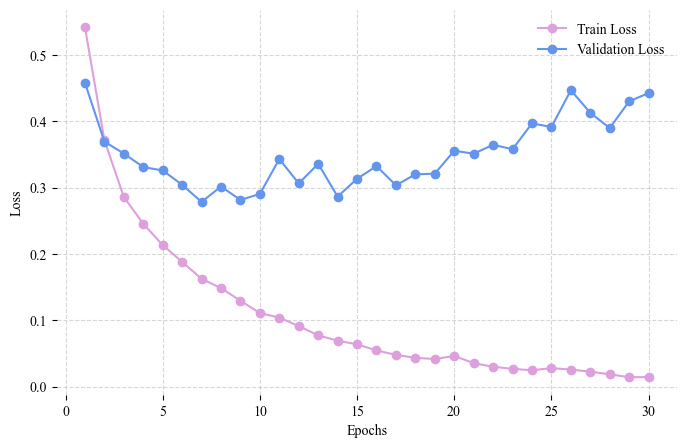

In [10]:
# Given data
epochs = list(range(1, 31))
train_loss = [0.5419, 0.3716, 0.2859, 0.2455, 0.2134, 0.1880, 0.1625, 0.1485, 0.1294, 0.1108,
              0.1040, 0.0912, 0.0772, 0.0692, 0.0637, 0.0545, 0.0478, 0.0434, 0.0415, 0.0462,
              0.0353, 0.0299, 0.0267, 0.0246, 0.0278, 0.0256, 0.0225, 0.0185, 0.0141, 0.0143]
val_loss = [0.4580, 0.3695, 0.3514, 0.3310, 0.3259, 0.3043, 0.2784, 0.3017, 0.2814, 0.2905,
            0.3431, 0.3064, 0.3359, 0.2865, 0.3133, 0.3325, 0.3035, 0.3200, 0.3211, 0.3556,
            0.3512, 0.3646, 0.3579, 0.3969, 0.3914, 0.4469, 0.4128, 0.3898, 0.4301, 0.4426]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker="o", color="plum")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o", color="cornflowerblue")
plt.xlabel("Epochs", fontname="Times New Roman")
plt.ylabel("Loss", fontname="Times New Roman")
plt.legend(prop={'family': 'Times New Roman'}, frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")
plt.savefig("nn_training_validation_loss.png", dpi=300, bbox_inches='tight')
plt.show()


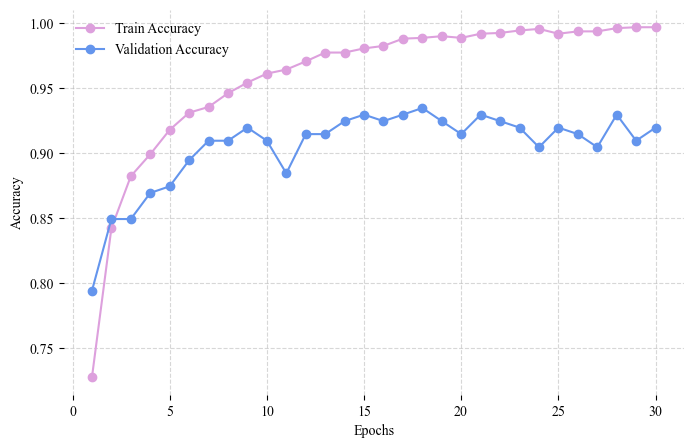

In [11]:
# Accuracy data
train_acc = [0.7274, 0.8421, 0.8822, 0.8991, 0.9179, 0.9311, 0.9355, 0.9461, 0.9543, 0.9612,
             0.9643, 0.9706, 0.9774, 0.9774, 0.9806, 0.9825, 0.9881, 0.9887, 0.9900, 0.9887,
             0.9919, 0.9925, 0.9944, 0.9956, 0.9919, 0.9937, 0.9937, 0.9962, 0.9969, 0.9969]
val_acc = [0.7940, 0.8492, 0.8492, 0.8693, 0.8744, 0.8945, 0.9095, 0.9095, 0.9196, 0.9095,
           0.8844, 0.9146, 0.9146, 0.9246, 0.9296, 0.9246, 0.9296, 0.9347, 0.9246, 0.9146,
           0.9296, 0.9246, 0.9196, 0.9045, 0.9196, 0.9146, 0.9045, 0.9296, 0.9095, 0.9196]

# Plotting accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o", color="plum")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o", color="cornflowerblue")
plt.xlabel("Epochs", fontname="Times New Roman")
plt.ylabel("Accuracy", fontname="Times New Roman")
plt.legend(prop={'family': 'Times New Roman'}, frameon=False)

# Add faint grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Remove the box outline
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set font for all tick labels
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")

# Save the plot
plt.savefig("nn_training_validation_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()


In [20]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

TORGO_FOLDER = "data/torgo_data"
csv_path = os.path.join(TORGO_FOLDER, "data.csv")
df = pd.read_csv(csv_path)

def fix_path(relative_path):
    prefix = "torgo_data/"
    if relative_path.startswith(prefix):
        relative_path = relative_path[len(prefix):]
    return os.path.join(TORGO_FOLDER, relative_path)

df['audio_path'] = df['filename'].apply(fix_path)


bad_files = {
    "data/torgo_data/dysarthria_female/F01_Session1_0068.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0344.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0346.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0356.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0360.wav"
}
df = df[~df['audio_path'].isin(bad_files)]
df['label'] = df['is_dysarthria'].apply(lambda x: 1 if x == 'dysarthria' else 0)
df_train, df_temp = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=seed, stratify=df_temp['label'])


feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

for param in wav2vec_model.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec_model.to(device)
wav2vec_model.eval()

class Wav2VecDataset(Dataset):
    def __init__(self, df, feature_extractor, wav2vec_model, sr=16000):
        self.df = df.reset_index(drop=True)
        self.feature_extractor = feature_extractor
        self.wav2vec_model = wav2vec_model
        self.sr = sr
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row["audio_path"]
        label = row["label"]
        # Load raw audio
        y, _ = librosa.load(audio_path, sr=self.sr)
        # Process audio to get input_values for Wav2Vec2
        inputs = self.feature_extractor(y, sampling_rate=self.sr, return_tensors="pt", padding=True)
        # Move to the same device as the wav2vec model
        inputs = {key: value.to(device) for key, value in inputs.items()}
        # Extract embeddings with Wav2Vec2 (no gradient needed)
        with torch.no_grad():
            outputs = self.wav2vec_model(**inputs)
        # Mean-pool the hidden states to obtain a fixed-size vector (shape: 768)
        hidden_states = outputs.last_hidden_state  # shape: (1, time, 768)
        embedding = hidden_states.mean(dim=1).squeeze()  # shape: (768,)
        # Return embedding on CPU and label
        return embedding.cpu(), label


class Wav2VecClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, num_classes=2):
        super(Wav2VecClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

batch_size = 8
train_dataset = Wav2VecDataset(df_train, feature_extractor, wav2vec_model)
val_dataset   = Wav2VecDataset(df_val, feature_extractor, wav2vec_model)
test_dataset  = Wav2VecDataset(df_test, feature_extractor, wav2vec_model)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

model = Wav2VecClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for embeddings, labels in dataloader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * embeddings.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in dataloader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * embeddings.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30 - Train Loss: 0.6431 - Train Acc: 0.6360 - Val Loss: 0.5843 - Val Acc: 0.7085
Epoch 2/30 - Train Loss: 0.5505 - Train Acc: 0.7212 - Val Loss: 0.6302 - Val Acc: 0.6231
Epoch 3/30 - Train Loss: 0.5119 - Train Acc: 0.7500 - Val Loss: 0.5530 - Val Acc: 0.7437
Epoch 4/30 - Train Loss: 0.4768 - Train Acc: 0.7657 - Val Loss: 0.5386 - Val Acc: 0.7688
Epoch 5/30 - Train Loss: 0.4644 - Train Acc: 0.7713 - Val Loss: 0.5682 - Val Acc: 0.7337
Epoch 6/30 - Train Loss: 0.4578 - Train Acc: 0.7719 - Val Loss: 0.5647 - Val Acc: 0.7337
Epoch 7/30 - Train Loss: 0.4459 - Train Acc: 0.7870 - Val Loss: 0.5327 - Val Acc: 0.7688
Epoch 8/30 - Train Loss: 0.4239 - Train Acc: 0.7957 - Val Loss: 0.5274 - Val Acc: 0.7588
Epoch 9/30 - Train Loss: 0.4166 - Train Acc: 0.8076 - Val Loss: 0.5264 - Val Acc: 0.7688
Epoch 10/30 - Train Loss: 0.4044 - Train Acc: 0.8026 - Val Loss: 0.5834 - Val Acc: 0.7286
Epoch 11/30 - Train Loss: 0.3974 - Train Acc: 0.8177 - Val Loss: 0.5341 - Val Acc: 0.7538
Epoch 12/30 - Train


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.82      0.80      0.81       100
  Dysarthric       0.80      0.82      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



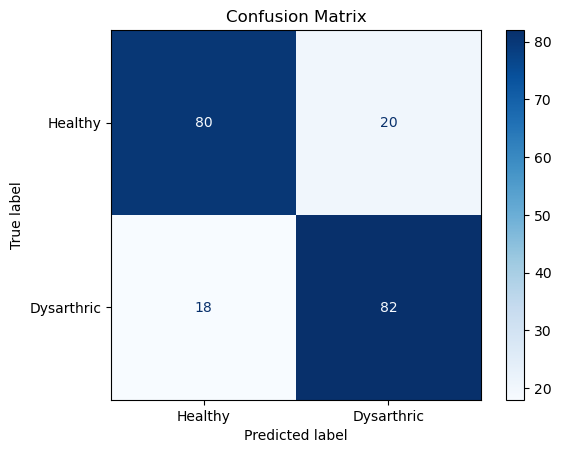

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for embeddings, labels in dataloader:
            embeddings = embeddings.to(device)
            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)
    
y_pred, y_true = get_all_preds(model, test_loader, device)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Healthy", "Dysarthric"]))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Dysarthric"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


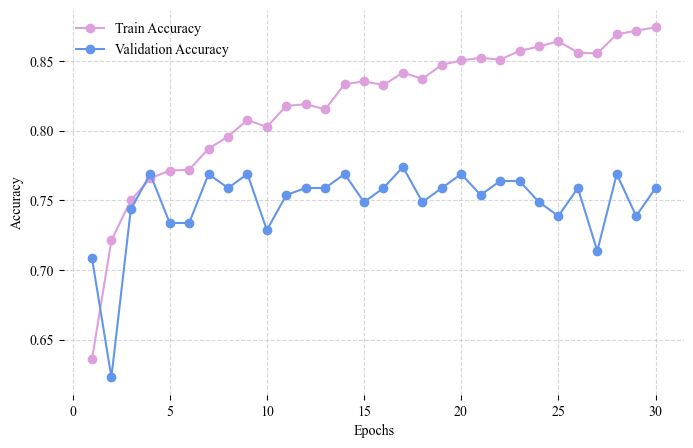

In [24]:

train_acc = [0.6360, 0.7212, 0.7500, 0.7657, 0.7713, 0.7719, 0.7870, 0.7957, 0.8076, 0.8026,
               0.8177, 0.8189, 0.8152, 0.8333, 0.8352, 0.8327, 0.8415, 0.8371, 0.8471, 0.8503,
               0.8521, 0.8509, 0.8571, 0.8603, 0.8640, 0.8559, 0.8553, 0.8690, 0.8716, 0.8741]
val_acc = [0.7085, 0.6231, 0.7437, 0.7688, 0.7337, 0.7337, 0.7688, 0.7588, 0.7688, 0.7286,
             0.7538, 0.7588, 0.7588, 0.7688, 0.7487, 0.7588, 0.7739, 0.7487, 0.7588, 0.7688,
             0.7538, 0.7638, 0.7638, 0.7487, 0.7387, 0.7588, 0.7136, 0.7688, 0.7387, 0.7588]

# Plotting accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o", color="plum")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o", color="cornflowerblue")
plt.xlabel("Epochs", fontname="Times New Roman")
plt.ylabel("Accuracy", fontname="Times New Roman")
plt.legend(prop={'family': 'Times New Roman'}, frameon=False)

# Add faint grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Remove the box outline
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set font for all tick labels
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")

# Save the plot
plt.savefig("nf_training_validation_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()


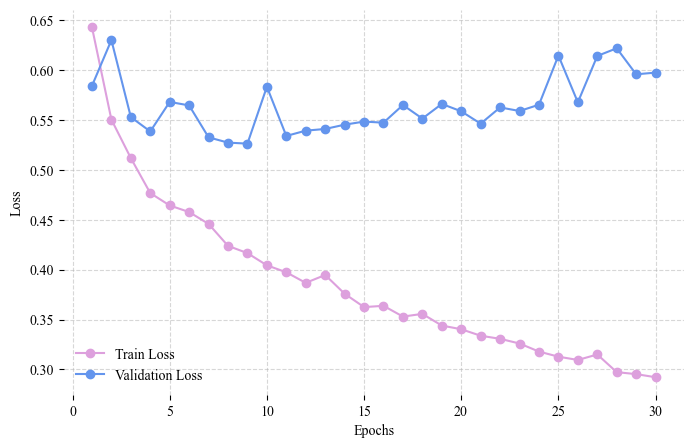

In [23]:

epochs = list(range(1, 31))
train_loss = [0.6431, 0.5505, 0.5119, 0.4768, 0.4644, 0.4578, 0.4459, 0.4239, 0.4166, 0.4044,
                0.3974, 0.3868, 0.3947, 0.3759, 0.3625, 0.3638, 0.3530, 0.3557, 0.3440, 0.3403,
                0.3338, 0.3307, 0.3260, 0.3179, 0.3128, 0.3095, 0.3150, 0.2973, 0.2953, 0.2922]
val_loss = [0.5843, 0.6302, 0.5530, 0.5386, 0.5682, 0.5647, 0.5327, 0.5274, 0.5264, 0.5834,
              0.5341, 0.5394, 0.5411, 0.5454, 0.5485, 0.5474, 0.5651, 0.5515, 0.5662, 0.5588,
              0.5464, 0.5627, 0.5591, 0.5654, 0.6147, 0.5678, 0.6143, 0.6220, 0.5959, 0.5976]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker="o", color="plum")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o", color="cornflowerblue")
plt.xlabel("Epochs", fontname="Times New Roman")
plt.ylabel("Loss", fontname="Times New Roman")
plt.legend(prop={'family': 'Times New Roman'}, frameon=False)
plt.grid(True, linestyle='--', alpha=0.5)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")
plt.savefig("nf_training_validation_loss.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#RESULTS DISPLAYED IN THE FINETUNING NOTEBOOK

import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

TORGO_FOLDER = "data/torgo_data"
csv_path = os.path.join(TORGO_FOLDER, "data.csv")
df = pd.read_csv(csv_path)

def fix_path(relative_path):
    prefix = "torgo_data/"
    if relative_path.startswith(prefix):
        relative_path = relative_path[len(prefix):]
    return os.path.join(TORGO_FOLDER, relative_path)

df['audio_path'] = df['filename'].apply(fix_path)
df['label'] = df['is_dysarthria'].apply(lambda x: 1 if x == 'dysarthria' else 0)


corrupted_files = {
    "data/torgo_data/dysarthria_female/F01_Session1_0068.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0344.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0346.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0356.wav",
    "data/torgo_data/dysarthria_male/M05_Session2_0360.wav"
}

df = df[~df["audio_path"].isin(corrupted_files)].reset_index(drop=True)


df_train, df_temp = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=seed, stratify=df_temp['label'])

print(f" Dataset filtered! Remaining files: {len(df)}")


model_name = "facebook/wav2vec2-base-960h"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

wav2vec_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name, num_labels=2,  # Binary classification (Healthy vs. Dysarthria)
    attention_dropout=0.1,
    hidden_dropout=0.1
)


for param in wav2vec_model.parameters():
    param.requires_grad = True

for name, param in wav2vec_model.named_parameters():
    if "layer_norm" in name:
        param.requires_grad = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec_model.to(device)


class Wav2VecDataset(Dataset):
    def __init__(self, df, sr=16000):
        self.df = df.reset_index(drop=True)
        self.sr = sr
       
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row["audio_path"]
        label = row["label"]
       
        if audio_path in corrupted_files:
            print(f"Skipping corrupted file: {audio_path}")
            return None
       
        try:
            y, _ = librosa.load(audio_path, sr=self.sr)
            return y, label
        except Exception as e:
            print(f"Error loading file: {audio_path} - Skipping. Error: {e}")
            return None

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
   
    if len(batch) == 0:
        return torch.zeros((1, 16000)), torch.ones((1, 16000)), torch.tensor([0])

    raw_audios, labels = zip(*batch)
    raw_audios = [np.array(audio, dtype=np.float32) for audio in raw_audios]

    inputs = feature_extractor(
        raw_audios, sampling_rate=16000, return_tensors="pt", padding=True, return_attention_mask=True
    )

    return inputs["input_values"], inputs["attention_mask"], torch.tensor(labels, dtype=torch.long)

batch_size = 8
train_loader = DataLoader(Wav2VecDataset(df_train), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(Wav2VecDataset(df_val), batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(Wav2VecDataset(df_test), batch_size=batch_size, collate_fn=collate_fn)


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for input_values, attention_mask, labels in dataloader:
        input_values = input_values.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_values=input_values, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for input_values, attention_mask, labels in dataloader:
            input_values = input_values.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_values=input_values, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            running_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {'params': wav2vec_model.wav2vec2.parameters(), 'lr': 1e-6},
    {'params': wav2vec_model.classifier.parameters(), 'lr': 1e-5}
], weight_decay=1e-4)

num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(wav2vec_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(wav2vec_model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
test_loss, test_acc = evaluate(wav2vec_model, test_loader, criterion, device)
print(f"\n✅ Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")


In [ ]:
#RESULTS DISPLAYED IN THE FINETUNING NOTEBOOK

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, attention_mask, labels in dataloader:
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            logits = model(input_values=inputs, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_predictions(wav2vec_model, test_loader, device)
print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Dysarthria"], yticklabels=["Healthy", "Dysarthria"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion Matrix", dpi=300, bbox_inches='tight')  
plt.show()


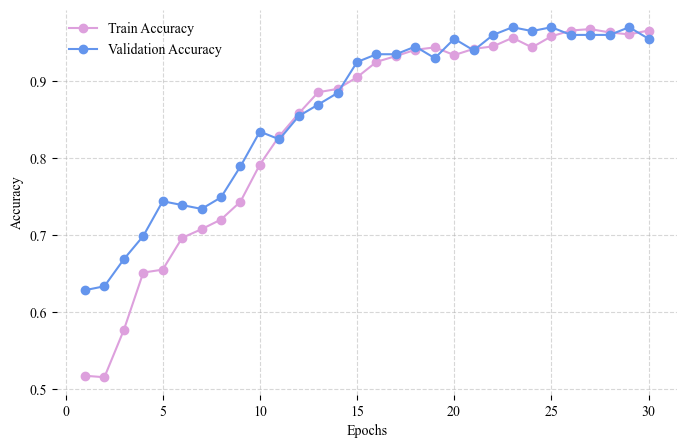

In [6]:
#TRAINING AND VALIDATION ACCURACY CURVE

import matplotlib.pyplot as plt

train_acc = [0.5169, 0.5150, 0.5764, 0.6510, 0.6548, 0.6961, 0.7074, 0.7199, 0.7431, 0.7914,
             0.8283, 0.8578, 0.8853, 0.8897, 0.9048, 0.9248, 0.9323, 0.9405, 0.9436, 0.9336,
             0.9417, 0.9449, 0.9561, 0.9436, 0.9580, 0.9655, 0.9674, 0.9630, 0.9605, 0.9655]
val_acc = [0.6281, 0.6332, 0.6683, 0.6985, 0.7437, 0.7387, 0.7337, 0.7487, 0.7889, 0.8342,
           0.8241, 0.8543, 0.8693, 0.8844, 0.9246, 0.9347, 0.9347, 0.9447, 0.9296, 0.9548,
           0.9397, 0.9598, 0.9698, 0.9648, 0.9698, 0.9598, 0.9598, 0.9598, 0.9698, 0.9548]

epochs = range(1, len(train_acc) + 1)  

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o", color="plum")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o", color="cornflowerblue")
plt.xlabel("Epochs", fontname="Times New Roman")
plt.ylabel("Accuracy", fontname="Times New Roman")
plt.legend(prop={'family': 'Times New Roman'}, frameon=False)

# Add faint grid lines
plt.grid(True, linestyle='--', alpha=0.5)  
# Remove the box outline
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set font for all tick labels
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")

plt.savefig("training_validation_accuracy.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

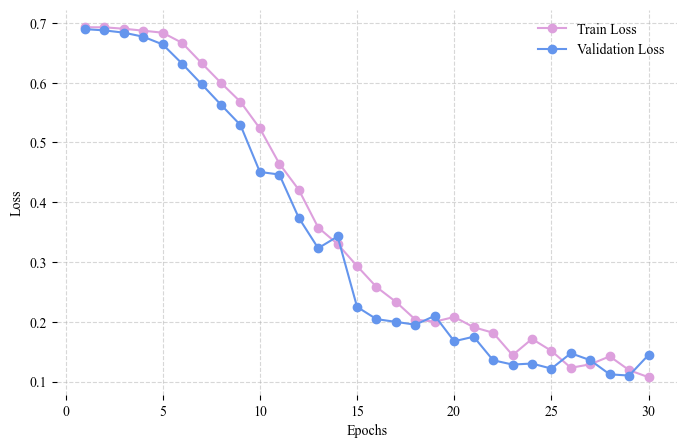

In [7]:
#TRAINING AND VALIDATION ACCURACY CURVE

import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(1, 31))
train_loss = [0.6929, 0.6927, 0.6904, 0.6871, 0.6837, 0.6667, 0.6329, 0.5997, 0.5681, 0.5235,
              0.4646, 0.4210, 0.3577, 0.3300, 0.2933, 0.2581, 0.2333, 0.2036, 0.2002, 0.2080,
              0.1909, 0.1816, 0.1441, 0.1713, 0.1513, 0.1230, 0.1288, 0.1421, 0.1190, 0.1072]
val_loss = [0.6897, 0.6876, 0.6838, 0.6770, 0.6641, 0.6319, 0.5977, 0.5631, 0.5292, 0.4507,
            0.4464, 0.3740, 0.3231, 0.3428, 0.2249, 0.2044, 0.1998, 0.1951, 0.2100, 0.1674,
            0.1750, 0.1356, 0.1284, 0.1301, 0.1216, 0.1473, 0.1357, 0.1120, 0.1100, 0.1447]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker="o", color="plum")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o", color="cornflowerblue")
plt.xlabel("Epochs", fontname="Times New Roman")
plt.ylabel("Loss", fontname="Times New Roman")
plt.legend(prop={'family': 'Times New Roman'}, frameon=False)

# Add faint grid lines
plt.grid(True, linestyle='--', alpha=0.5)  

# Remove the box outline
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set font for all tick labels
plt.xticks(fontname="Times New Roman")
plt.yticks(fontname="Times New Roman")

plt.savefig("training_validation_loss.png", dpi=300, bbox_inches='tight')  
plt.show()